In [2]:
from zipfile import ZipFile
import torchvision
import os
from scipy.io import loadmat
from sklearn.model_selection import StratifiedShuffleSplit
import collections
import numpy as np
from torch.utils.data import Dataset,DataLoader
from torchvision.models.segmentation import fcn_resnet50
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [99]:
# # specifying the zip file name
# file_name = "underwater_sem_seg.zip"
# #
# # # opening the zip file in READ mode
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()

#     # extracting all the files
#     print('Extracting all the files now...')
#     zip.extractall()
#     print('Done!')


In [100]:
# pip install torchvision

In [101]:
# os.listdir("underwater_sem_seg/dataset")

In [3]:
root = "underwater_sem_seg/dataset"

entries = os.listdir(root)
entries.remove("indices_files")
entries.remove('.DS_Store')
print(entries)
folders = [root+"/"+i for i in entries[1:]]
print(folders)
# entries = os.listdir(folders[0])
# print(entries)
images = []
masks = []
imclasses = []
for folder in folders:
    entries = os.listdir(folder)
    for image_data in entries:
#         print(folder+"/"+image_data)
        mat = loadmat(folder+"/"+image_data)
        # print(mat)
        images.append(np.asarray(mat["image_array"]))
        imclasses.append(mat["class"])
        masks.append(np.asarray(mat["mask_array"]))
        # images.append((imclass,image,mask_array))
    # break

print(len(images))
print(images[0].shape)


['dolphin_sem_seg_gt', 'crocodile_sem_seg_gt', 'seal_sem_seg_gt', 'sea_anemone_sem_seg_gt', 'squid_sem_seg_gt', 'turtle_sem_seg_gt', 'sea_urchin_sem_seg_gt', 'penguin_sem_seg_gt', 'whale_sem_seg_gt', 'frog_sem_seg_gt', 'crab_sem_seg_gt', 'otter_sem_seg_gt', 'nettles_sem_seg_gt', 'shark_sem_seg_gt', 'polar_bear_sem_seg_gt', 'shrimp_sem_seg_gt', 'star_fish_sem_seg_gt', 'octopus_sem_seg_gt', 'seahorse_sem_seg_gt', 'stingray_sem_seg_gt', 'nudibranch_sem_seg_gt']
['underwater_sem_seg/dataset/crocodile_sem_seg_gt', 'underwater_sem_seg/dataset/seal_sem_seg_gt', 'underwater_sem_seg/dataset/sea_anemone_sem_seg_gt', 'underwater_sem_seg/dataset/squid_sem_seg_gt', 'underwater_sem_seg/dataset/turtle_sem_seg_gt', 'underwater_sem_seg/dataset/sea_urchin_sem_seg_gt', 'underwater_sem_seg/dataset/penguin_sem_seg_gt', 'underwater_sem_seg/dataset/whale_sem_seg_gt', 'underwater_sem_seg/dataset/frog_sem_seg_gt', 'underwater_sem_seg/dataset/crab_sem_seg_gt', 'underwater_sem_seg/dataset/otter_sem_seg_gt', 'und

In [4]:

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)

for train_index, test_index in split.split(images,imclasses):
    print(train_index,test_index)
    images_train = [images[i] for i in train_index]
    classes_train = [imclasses[i] for i in train_index]
    masks_train = [masks[i] for i in train_index]

    images_test = [images[i] for i in test_index]
    classes_test = [imclasses[i] for i in test_index]
    masks_test = [masks[i] for i in test_index]

print(len(images_train),len(images_test))

print(classes_train)
print(classes_test)

[266  20 462 238  86 445 357 153 337 293 343 116  70 135 138 517 248 205
 206 527 481 464 355  48 258 143  73  30 413 275 202 405 525  61 118 317
  56 375 475 276 533  50 402  67 323  47 187 436 446 457 125 320 220 273
  83 391 411 217 239  22 400 512 256 174  60 321 133 175  23  63 536 360
 487 284 440 165  31 421   0 447  79 114 222  52 214  71 113 111  58 136
 395 260 516 486 193 432 178 387 312 225 243 465 363 246 139 101  78 161
 221 110 451 417 241 288 346 294  43 132 190 310 469 455 196 172 212  51
 263  93 115 460 374 259   1 478 528 318 215 526 371 229 292  28 326 428
  34  95 333 173 127  99  84 253 267  72  39 254 338 349 324 219 418 210
 261 126 429 105 541 180 348 344 378  62 331 476 531 197  12 403 144 194
 502 185 508 244 492  46 155 461 108  91 473 298 150 524 347 189 376 498
 404 366 398 304   4 511 474  55  21  57 278 520 179 191 224 450  37 356
 424 383 537 141 414 200 361 484 329  68 334  29 544 236 530 406 285 279
 407 289 183 316   5   9 350 534 152  87 250 158 38

In [5]:
class myDataset(Dataset):
    def __init__(self,input_data,mask,transform):
        self.input=input_data
        self.mask = mask
        self.transforms = transform

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        x=self.input[index]
        z=self.mask[index]
#         print(x,z)
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            x = self.transforms(x)
            z = self.transforms(z)
        return x,z

class hyperparam:
    num_classes=31
    num_workers=5
    bs=50
    epochs = 20
    HEIGHT= 256
    WIDTH = 256
# params = {shuffle=True,"batch_size" : hyperparam.bs, "num_workers":num_workers=os.cpu_count() ,"pin_memory" : False}


In [6]:
from torchvision import transforms

transforms = transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(256),transforms.ToTensor()])
#transforms.Resize((hyperparam.HEIGHT,hyperparam.WIDTH))
training_set = myDataset(images_train,masks_train,transforms)
test_set = myDataset(images_test,masks_test,transforms)

train_gen = DataLoader(training_set,shuffle=True,batch_size=hyperparam.bs, pin_memory=False,num_workers=os.cpu_count())
test_gen = DataLoader(test_set,shuffle=False,batch_size=2, pin_memory=False,num_workers=os.cpu_count())

In [27]:
class MyFCN(nn.Module):
    def __init__(self, num_classes, 
                 pretrained=True, 
                 criterion=nn.CrossEntropyLoss(ignore_index=255),
                 network_name='resnet50',
                 training=False):                    
        super(MyFCN, self).__init__()
        
        self.num_classes   = num_classes
        self.criterion     = criterion
        self.backbone_name = network_name
        self.training      = training        
        
        if pretrained:
            net = fcn_resnet50(pretrained=pretrained,                             
                            pretrained_backbone= True)
                
        #self.classifier = nn.Sequential(*[net.classifier[i] for i in range(5)])
        
        self.backbone   = net.backbone
        self.classifier = nn.Sequential(*list(net.classifier.children())[:-1])        
        self.last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        self.upsample1 = nn.ConvTranspose2d(num_classes, num_classes, (4,4), stride=4)
        self.upsample2 = nn.ConvTranspose2d(num_classes, num_classes, (2,2), stride=2)
        
        '''if self.training:
            self.aux_classifier = nn.Sequential(*list(net.aux_classifier.children())[:-1])        
            self.aux_last_layer = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
            '''

        
    def forward(self, x):
        
        x = self.backbone(x)
        x = x['out'] # the other key in the ordered dictionary is 'aux'
        #pdb.set_trace()
        x = self.classifier(x)
        x = self.last_layer(x) 
        x = self.upsample1(x)
        x = self.upsample2(x)
        
        if self.training:
            pdb.set_trace()
            main_loss = self.criterion(x, y)
            return x.max(1)[1], main_loss

            #aux       = self.aux_classifier(x_tmp)        
            #aux_loss  = self.criterion(aux, y)
            #return x.max(1)[1], main_loss, aux_loss
            
        else:
            return x                


In [28]:
# model = fcn_resnet50(pretrained=False, progress=False,num_classes=31,pretrained_backbone= True)
model = MyFCN(num_classes = 31)
# model = model.train(True)
# model

In [29]:
lossfunc = nn.CrossEntropyLoss()
# lossfunc = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.0007)

In [15]:
classes = ["crab","crocodile","dolphin","frog","nettles","octopus","otter","penguin","polar_bear","sea_anemone","sea_urchin","seahorse","seal","shark","shrimp","star_fish","stingray","squid","turtle","whale","nudibranch","coral","rock","water","sand","plant","human","iceberg","reef","fish","other"]

sem_class_to_idx = {cls: idx for (idx,cls) in enumerate(classes)}
# sem_class_to_idx

In [30]:
import torchvision.transforms.functional as F
testing_total_loss=[]
testing_loss=[]
model.eval()
print("here")
with torch.set_grad_enabled(False):
    print("here1")
    for batch,labels in test_gen:
#             print("here2")
        batch=batch.float()
        labels=labels.float()
        labels = ((labels - labels.min()) * (1/(labels.max() - labels.min())*31))
        print("batch size", batch.size())
#             batch,label=Variable(batch,requires_grad=True),Variable(labels,requires_grad=True)
#             print(batch,label)
        batch = F.normalize(batch,mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        predictions=model(batch)
        print("predictions" ,predictions)
        print("predictions size",predictions.size())
#         npred = torch.argmax(predictions.squeeze(),dim=1)
        predictions = predictions.type(torch.FloatTensor)
        npred = torch.nn.functional.softmax(predictions,dim =1)
        print("npred ", npred.size())
        labels = labels.squeeze(1)
        labels = labels.type(torch.LongTensor)
        print("label size", labels.size())
        pred_loss = lossfunc(npred,labels) 
        testing_loss.append(pred_loss)
#             print("pred_loss",pred_loss)
#         print("batch[0]",batch[0])
        masks = [
            npred[img_idx,sem_class_to_idx[cls]]
            for img_idx in range(batch.shape[0])
            for cls in classes]
        break


here
here1
batch size torch.Size([2, 3, 256, 256])
predictions tensor([[[[-0.0607, -0.0343, -0.0509,  ..., -0.0551, -0.0519, -0.0543],
          [-0.0535, -0.0648, -0.0508,  ..., -0.0514, -0.0363, -0.0369],
          [-0.0676, -0.0452, -0.0466,  ..., -0.0583, -0.0445, -0.0594],
          ...,
          [-0.0480, -0.0663, -0.0351,  ..., -0.0562, -0.0387, -0.0423],
          [-0.0470, -0.0527, -0.0446,  ..., -0.0468, -0.0635, -0.0572],
          [-0.0432, -0.0449, -0.0374,  ..., -0.0515, -0.0329, -0.0588]],

         [[ 0.0031,  0.0170, -0.0084,  ...,  0.0197, -0.0048,  0.0173],
          [-0.0040,  0.0135,  0.0303,  ...,  0.0141,  0.0042,  0.0096],
          [-0.0182,  0.0330,  0.0039,  ...,  0.0205,  0.0031,  0.0175],
          ...,
          [ 0.0207,  0.0070,  0.0195,  ...,  0.0172,  0.0356,  0.0033],
          [ 0.0040,  0.0248,  0.0020,  ...,  0.0205, -0.0124,  0.0249],
          [ 0.0136,  0.0128,  0.0093,  ...,  0.0097,  0.0187,  0.0178]],

         [[ 0.0781,  0.0706,  0.0709,  

In [31]:
print("testing_total_loss",testing_loss)


testing_total_loss [tensor(3.4339)]


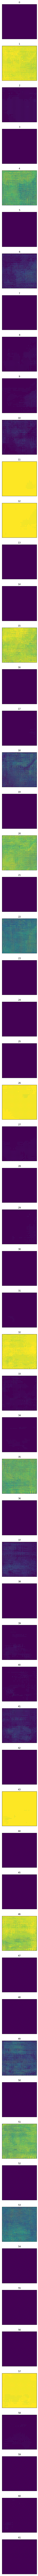

In [47]:

import matplotlib.pyplot as plt
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(nrows=len(imgs),figsize= (256,256),squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[i, 0].imshow(np.asarray(img))
        axs[i,0].set_title(str(i))
        axs[i, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
i = 0        
show(masks)

In [ ]:
# from PIL import Image
# import torchvision.transforms as T
# transform = T.ToPILImage(mode = np.dtype(float))
# img = npred
# # img = torch.argmax(npred.squeeze(),dim=1)
# print(img.size())
# print(img[0].max())
# image = transform(img[0])
# new_im = ((npred - npred.min()) * (1/(npred.max() - npred.min()) * 255))
# new_im.max()
# image = transform(new_im)

In [ ]:
# image

In [ ]:
transform = T.ToPILImage()
image = transform(batch[1])
image